In [2]:
import json
import requests
from shapely.geometry import Polygon
import folium
from shapely.ops import transform
import pyproj
import h3
from sqlalchemy.dialects.oracle.dictionary import all_mviews

from agent_components.memory.long_term_memory import LongTermMemory
from agent_components.llms.chatAI import ChatAIHandler
from evaluation.candidate_generation_evaluation import CustomJSONEncoder
import re
import pandas as pd
import os

In [3]:
with open(r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\data\processed_GeoCoDe_test.json", "r", encoding="utf-8") as f:
    geocode_test_set = json.load(f)

In [4]:
geocode_test_set

[{'article_id': '9326279',
  'article_text': 'The Gulf of Oman or Sea of Oman (Arabic: خَلِيج عُمَان\u200e khalīj ʿumān; Persian: دریای عمان\u200e daryâ-ye omân) is a gulf that connects the Arabian Sea with the Strait of Hormuz, which then runs to the Persian Gulf. It borders Iran and Pakistan on the north, Oman on the south, and the United Arab Emirates on the west.',
  'toponyms': ['Arabian Sea',
   'Strait of Hormuz',
   'Persian Gulf',
   'Iran',
   'Pakistan',
   'Oman',
   'United Arab Emirates'],
  'toponym_data': [{'osm_id': '9328393',
    'coordinates': {'latitude': 12.436798, 'longitude': 62.073997},
    'toponym': 'Arabian Sea'},
   {'osm_id': '9326284',
    'coordinates': {'latitude': 26.4496678, 'longitude': 56.2798177},
    'toponym': 'Strait of Hormuz'},
   {'osm_id': '9326283',
    'coordinates': {'latitude': 27.2380905, 'longitude': 51.7498926},
    'toponym': 'Persian Gulf'},
   {'osm_id': '304938',
    'coordinates': {'latitude': 32.3088854, 'longitude': 53.6825806},

In [5]:
geo_relatable_harsh = [
    article for article in geocode_test_set
    if (any(word in article["article_text"] for word in ["lies", "located"]) and
        " is a " in article["article_text"] and
        any(word in article["article_text"] for word in ["km", "kilometer", "kilometre"]))
        #and not "area" in article["article_text"])
]
print(len(geo_relatable_harsh))
geo_relatable_harsh

204


[{'article_id': '1953975',
  'article_text': "Leningrad Nuclear Power Plant (Russian: Ленинградская атомная электростанция; Ленинградская АЭС (pronunciation\xa0(help·info))) is a nuclear power plant located in the town of Sosnovy Bor in Russia's Leningrad Oblast, on the southern shore of the Gulf of Finland, some 70 kilometres (43\xa0mi) to the west of the city centre of Saint Petersburg.",
  'toponyms': ["Russia's",
   'Leningrad Oblast',
   'Gulf of Finland',
   'Saint Petersburg'],
  'toponym_data': [{'osm_id': '60189',
    'coordinates': {'latitude': 61.62186, 'longitude': -74.7863859},
    'toponym': "Russia's"},
   {'osm_id': '176095',
    'coordinates': {'latitude': 59.8732948, 'longitude': 31.070656},
    'toponym': 'Leningrad Oblast'},
   {'osm_id': '9408222',
    'coordinates': {'latitude': 59.8737466, 'longitude': 26.3763389},
    'toponym': 'Gulf of Finland'},
   {'osm_id': '337422',
    'coordinates': {'latitude': 59.9393101, 'longitude': 30.0926255},
    'toponym': 'Saint

In [6]:
with open(
        r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\reflective_candidate_resolution\fatal_error_and_invalid_correction\GeoCoDe\meta-llama-3.1-8b-instruct_with_meta-llama-3.1-8b-instruct_critic\20250122_seed_24_1000_articles\correct_articles_k_161.json", "r", encoding="utf-8") as f:
    correctly_geocoded_articles = json.load(f)
print(len(correctly_geocoded_articles))
correctly_geocoded_articles

154


[{'article_id': '10025588',
  'article_text': '110\xa0megawatt (MW) net[3] solar thermal power project with 1.1 gigawatt-hours of energy storage,[1] located near Tonopah, about 190 miles (310\xa0km) northwest of Las Vegas.[4][5]It substantially missed its intended power production by only achieving about 40% of its capacity on an annual basis, resulting in lawsuits and changes of control.[6][7] The site has not produced power since April 2019, and its sole customer has cancelled their contract.[8] While falling far short of its electrical capacity, Crescent Dunes was the first concentrated solar power (CSP) plant with a central receiver tower and advanced molten salt energy storage technology from SolarReserve.',
  'toponyms': ['Tonopah', 'Las Vegas'],
  'toponym_data': [{'osm_id': '170155',
    'coordinates': {'latitude': 38.0999749, 'longitude': -117.2506197},
    'toponym': 'Tonopah'},
   {'osm_id': '170117',
    'coordinates': {'latitude': 36.2551973, 'longitude': -115.2431753},
  

In [7]:
geo_relatable_harsh_from_geocoded_articles = [
    article for article in correctly_geocoded_articles
    if (any(word in article["article_text"] for word in ["lies", "located"]) and
        any(word in article["article_text"] for word in ["km", "kilometer", "kilometre"]))
        #and not "area" in article["article_text"])
]
print(len(geo_relatable_harsh_from_geocoded_articles))
print(f"# Toponyms: {sum(len(article['toponyms']) for article in geo_relatable_harsh_from_geocoded_articles)}")
geo_relatable_harsh_from_geocoded_articles

46
# Toponyms: 218


[{'article_id': '10025588',
  'article_text': '110\xa0megawatt (MW) net[3] solar thermal power project with 1.1 gigawatt-hours of energy storage,[1] located near Tonopah, about 190 miles (310\xa0km) northwest of Las Vegas.[4][5]It substantially missed its intended power production by only achieving about 40% of its capacity on an annual basis, resulting in lawsuits and changes of control.[6][7] The site has not produced power since April 2019, and its sole customer has cancelled their contract.[8] While falling far short of its electrical capacity, Crescent Dunes was the first concentrated solar power (CSP) plant with a central receiver tower and advanced molten salt energy storage technology from SolarReserve.',
  'toponyms': ['Tonopah', 'Las Vegas'],
  'toponym_data': [{'osm_id': '170155',
    'coordinates': {'latitude': 38.0999749, 'longitude': -117.2506197},
    'toponym': 'Tonopah'},
   {'osm_id': '170117',
    'coordinates': {'latitude': 36.2551973, 'longitude': -115.2431753},
  

# Run LLM GeoRelation for all fully correctly geocoded georelatable articles

In [8]:
with open(
        r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\reflective_candidate_resolution\fatal_error_and_invalid_correction\GeoCoDe\meta-llama-3.1-8b-instruct_with_meta-llama-3.1-8b-instruct_critic\20250122_seed_24_1000_articles\articles_with_at_least_one_correct_toponym_k_161.json", "r", encoding="utf-8") as f:
    correctly_geocoded_articles = json.load(f)

In [9]:
def georelate(model_name, long_term_memory, article_text, mentioned_toponyms):
    prompt = long_term_memory.generate_georelation_prompt(article_text=article_text,
                                                          mentioned_toponyms=mentioned_toponyms,
                                                          example_path=r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\data\few_shot_example_georelation.json")
    handler = ChatAIHandler()
    model = handler.get_model(model_name)
    llm_answer = model.invoke(prompt)
    pattern = re.compile(r"<think>(.*?)</think>", re.DOTALL)

    thoughts = pattern.findall(llm_answer.content)  # Extract thoughts
    non_thoughts = pattern.sub("", llm_answer.content)  # Remove thoughts from text
    start = non_thoughts.find("```json")
    if start != -1:
        start = start + 7
        end = non_thoughts.find("```", start)  # Find the next occurrence after start
        content = non_thoughts[start:end]
        prediction = json.loads(content)
    elif non_thoughts.find("```") != -1:
        start = start + 4
        end = non_thoughts.find("```", start)  # Find the next occurrence after start
        content = non_thoughts[start:end]
        prediction = json.loads(content)
    else:
        prediction = json.loads(llm_answer.content)
    return thoughts, prediction

model_name = "llama-3.3-70b-instruct" #"deepseek-r1-distill-llama-70b"
directory = f'output/georelation/all_articles_with_at_lest_one_correctly_geocoded_toponym/{model_name}/{pd.Timestamp.now().strftime("%Y%m%d")}'
output_directory = os.path.join(r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms",
                                directory)
os.makedirs(output_directory, exist_ok=True)

ltm = LongTermMemory(documentation_file=r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\agent_components\memory\external_tool_documentation\geonames_websearch_documentation.md")
handler = ChatAIHandler()
model = handler.get_model(model_name)
for article in correctly_geocoded_articles:
    if os.path.exists(f"{output_directory}/{article['article_id']}.json"):
        continue
    prediction = georelate(model, ltm, article['article_text'], article['correctly_geocoded_toponyms'])
    if prediction:
        article.update({"georelation": prediction})
        # save article to json file in a specified directory
        try:
            with open(f"{output_directory}/{article['article_id']}.json", "w", encoding="utf-8") as f:
                json.dump(article, f, ensure_ascii=False, indent=4)
        except Exception as e:
            article_ids = article["article_id"].split()
            last_id = article_ids[-1]  # Get last ID
            with open(f"{output_directory}/{last_id}.json", "w", encoding="utf-8") as f:
                json.dump(article, f, ensure_ascii=False, indent=4)

# Add ground truth center coordinates, bounding box and approx area to articles

In [10]:
def get_bounding_box(relation_id):
    query = f"""
    [out:json];
    relation({relation_id});
    out geom;
    """
    try:
        url = "https://overpass-api.de/api/interpreter"
        response = requests.post(url, data={"data": query})
        data = response.json()

        if not data['elements']:
            return None, None, None, None

        relation = data['elements'][0]
        if 'bounds' not in relation:
            return None, None, None, None

        bounds = relation['bounds']
        min_lat = bounds['minlat']
        max_lat = bounds['maxlat']
        min_lon = bounds['minlon']
        max_lon = bounds['maxlon']

        return min_lat, max_lat, min_lon, max_lon

    except Exception as e:
        print(f"Error fetching relation {relation_id}: {e}")
        return None, None, None, None

def get_osm_admin_center(osm_id):
    """
    Query Overpass API for the admin_center or center of the given OSM ID.
    """
    query = f"""
    [out:json];
    relation({osm_id});
    out center;
    """

    url = "https://overpass-api.de/api/interpreter"
    response = requests.get(url, params={"data": query})

    if response.status_code == 200:
        data = response.json()
        elements = data.get("elements", [])

        for element in elements:
            if "center" in element:
                return element["center"]  # Returns {lat, lon}

    return None  # Return None if no center/admin_center is found

def get_area_sq_km(geometry, source_crs="EPSG:4326", target_crs="EPSG:3857"):
    project = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True).transform
    projected_geometry = transform(project, geometry)
    area_sq_km = projected_geometry.area / 1_000_000
    return area_sq_km


def process_articles(articles):
    """
    Extracts the last ID from article_id and fetches its coordinates.
    """
    processed_articles = []
    results = {}

    for article in articles:
        article_ids = article["article_id"].split()
        last_id = article_ids[-1]  # Get last ID

        centroid_coords = get_osm_admin_center(last_id)

        bb_min_lat, bb_max_lat, bb_min_lon, bb_max_lon = get_bounding_box(last_id)
        if all((bb_min_lat, bb_max_lat, bb_min_lon, bb_max_lon)):
            bounding_box_polygon = Polygon([(bb_min_lon, bb_min_lat), (bb_min_lon, bb_max_lat),
                                        (bb_max_lon, bb_max_lat), (bb_max_lon, bb_min_lat)])

            bb_area = get_area_sq_km(bounding_box_polygon)
            if centroid_coords and bb_area:
                article.update({'gt': {'centroid': centroid_coords,
                                       'bounding_box':{
                                           'bb_min_lat': bb_min_lat,
                                           'bb_max_lat': bb_max_lat,
                                           'bb_min_lon': bb_min_lon,
                                           'bb_max_lon': bb_max_lon
                                       },
                                       'bb area': bb_area}})
                processed_articles.append(article)

    return processed_articles

In [11]:
# articles_for_georelation = process_articles(correctly_geocoded_articles)

In [12]:
with open(r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\georelation\all_articles_with_at_lest_one_correctly_geocoded_toponym\articles_for_georelation.json", "r", encoding="utf-8") as f:
    articles_for_georelation = json.load(f)
len(articles_for_georelation)

510

# H3: Resolution handling

In [13]:
import pandas as pd
import numpy as np

# Define H3 resolutions with their corresponding hexagon areas (from table)
h3_data = [
    (0, 4357449.416078381),
    (1, 609788.441794133),
    (2, 86801.780398997),
    (3, 12393.434655088),
    (4, 1770.347654491),
    (5, 252.903858182),
    (6, 36.129062164),
    (7, 5.161293360),
    (8, 0.737327598),
    (9, 0.105332513),
    (10, 0.015047502),
    (11, 0.002149643),
    (12, 0.000307092),
    (13, 0.000043870),
    (14, 0.000006267),
    (15, 0.000000895),
]

# Convert to DataFrame
df = pd.DataFrame(h3_data, columns=["Resolution", "Hexagon_Area_km2"])

def get_h3_resolution_scaled(area_km2):
    """Find the H3 resolution where the input area and hexagon area are most proportionate."""
    df["Scale_Diff"] = np.abs(np.log2(area_km2 / df["Hexagon_Area_km2"]))
    closest_resolution = df.loc[df["Scale_Diff"].idxmin()]
    return int(closest_resolution["Resolution"])

# # Example usage:
# input_area = 100  # Change this to your area in km²
# best_resolution = get_h3_resolution_scaled(input_area)
# print(f"Best H3 resolution for {input_area} km²: {best_resolution}")

# Parsing of Complex Location Descriptions Evaluation

In [83]:
from geopy.distance import geodesic
import os
import json

def load_json_file(directory: str, search_string: str):
    """
    Loops over all files in the specified directory and loads JSON files
    whose filenames contain the specified search string.

    :param directory: Path to the directory containing files.
    :param search_string: String to search for in filenames.
    :return: A dictionary with filenames as keys and loaded JSON content as values.
    """
    json_data = None

    if not os.path.isdir(directory):
        raise ValueError(f"The specified path '{directory}' is not a directory.")

    for filename in os.listdir(directory):
        if search_string in filename and filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                json_data = json.load(file)
                break
    return json_data

GEORELATION_DIR = r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\georelation\all_articles_with_at_lest_one_correctly_geocoded_toponym\llama-3.3-70b-instruct\20250206"
k = 161

all_error_distances = []
all_squared_area_diffs = []
all_log_q = []
all_normalized_area_diffs = []
evaluation_results = []
very_off_area_predictions = []

for gt_article in articles_for_georelation:
    eval_results_for_article = {}
    article_ids = gt_article["article_id"].split()
    last_id = article_ids[-1]  # Get last ID

    # first, load generation
    try:
        georelated_article = load_json_file(GEORELATION_DIR, gt_article["article_id"])
        if not georelated_article:
            for id in article_ids:
                georelated_article = load_json_file(GEORELATION_DIR, id)
                if georelated_article:
                    break
    except Exception as e:
        continue
    if not georelated_article:
        continue

    # calculate distance of coordinates
    gt_coordinates = (gt_article['gt']['centroid']['lat'],
                      gt_article['gt']['centroid']['lon'])
    predicted_coordinates = (georelated_article['georelation']['coordinates of geographical unit']['latitude'],
                             georelated_article['georelation']['coordinates of geographical unit']['longitude'])
    error_distance = geodesic(gt_coordinates, predicted_coordinates).kilometers
    all_error_distances.append(error_distance)

    # calculate area error distance
    gt_area = gt_article['gt']['bb area']
    predicted_area = georelated_article["georelation"]["area in square km"]

    log_q = np.log(predicted_area/gt_area)
    all_log_q.append(log_q)

    squared_area_diff = (predicted_area - gt_area)**2
    all_squared_area_diffs.append(squared_area_diff)

    normalized_error_diff = (predicted_area - gt_area) / gt_area
    if normalized_error_diff > 10:
        very_off_area_predictions.append(georelated_article)
    all_normalized_area_diffs.append(normalized_error_diff)

    # calculate intersection
    # Define an H3 cell
    h3_index = h3.latlng_to_cell(
        lat=georelated_article["georelation"]["coordinates of geographical unit"]["latitude"],
        lng=georelated_article["georelation"]["coordinates of geographical unit"]["longitude"],
        res=get_h3_resolution_scaled(predicted_area)
    )

    # Get the boundary coordinates of the H3 cell
    hexagon = h3.cell_to_boundary(h3_index)

    # Convert polygon to shapely format
    hexagon_coords = [(lng, lat) for lat, lng in hexagon]  # Convert to (lng, lat) for Folium
    hexagon_polygon = Polygon(hexagon_coords)
    hexagon_area_estimate = get_area_sq_km(hexagon_polygon)

    bb = gt_article['gt']['bounding_box']
    bb_min_lat, bb_max_lat, bb_min_lon, bb_max_lon = bb['bb_min_lat'], bb['bb_max_lat'], bb['bb_min_lon'], bb['bb_max_lon']
    bounding_box_polygon = Polygon([(bb_min_lon, bb_min_lat), (bb_min_lon, bb_max_lat),
                                    (bb_max_lon, bb_max_lat), (bb_max_lon, bb_min_lat)])
    intersection = bounding_box_polygon.intersection(hexagon_polygon)
    if not intersection.is_empty:
        intersection_area = get_area_sq_km(intersection)
    else:
        intersection_area = 0

    eval_results_for_article.update({"article_id": last_id,
                                     "gt": gt_article['gt'],
                                     "georelation": georelated_article['georelation'],
                                     "absolute_error_distance": error_distance,
                                     "squared_area_error": squared_area_diff,
                                     "log_q": log_q,
                                     "normalized_area_error": normalized_error_diff,
                                     "hexagon_area_estimate": hexagon_area_estimate,
                                     "area_intersection": intersection_area})
    evaluation_results.append(eval_results_for_article)

all_normalized_area_diffs = np.array(all_normalized_area_diffs)
# Accuracy@k
within_k = [d <= k for d in all_error_distances]
accuracy_at_k = sum(within_k) / len(all_error_distances)
print(f"Accuracy@{k}: {accuracy_at_k}")

# AUC
def calculate_auc(sorted_values):
    max_error = 20038  # Earth's circumference in km / 2 (maximum possible distance)
    size = len(sorted_values)
    if size <= 1:
        return 0.0

    h = 1  # step size
    sum = 0.5 * (np.log(1 + sorted_values[0]) / np.log(max_error) + np.log(
        1 + sorted_values[-1]) / np.log(max_error))  # initial area

    for i in range(1, size - 1):
        sum += np.log(1 + sorted_values[i]) / np.log(max_error)

    auc = sum * h / (size - 1)
    return auc

sorted_error_distances = sorted(
    all_error_distances)  # assuming error_distances is a dictionary with error error_distances
auc = calculate_auc(sorted_error_distances)
print(f"AUC: {auc}")

# Mean error distance
mean_error_distance = np.mean(all_error_distances)
print(f"Mean error distance: {mean_error_distance}")

# Median error distance
median_error_distance = np.median(all_error_distances)
print(f"Median error distance: {median_error_distance}")

# 𝜁 Median Symmetric Accuracy
abs_all_log_q = np.abs(all_log_q)
all_log_q = np.array(all_log_q)
zeta = 100 * (np.exp(np.median(abs_all_log_q)) - 1)
print(f"Median Symmetric Accuracy: {zeta}")

# SSPB
sspb = 100 * np.sign(np.median(all_log_q)) * (np.exp(np.abs(np.median(all_log_q))) - 1)
print(f"Symmetric Signed Percentage Bias: {sspb}")

print(f"nof very off area predictions: {len(very_off_area_predictions)}")


C:\Users\kaimo\AppData\Local\Temp\ipykernel_90324\1236644123.py:67: RuntimeWarning: divide by zero encountered in log
  log_q = np.log(predicted_area/gt_area)
C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Accuracy@161: 0.9784313725490196
AUC: 0.21337535584871656
Mean error distance: 66.39922292712099
Median error distance: 6.259998606264791
Median Symmetric Accuracy: 309.2394741041411
Symmetric Signed Percentage Bias: -273.1666877291654
nof very off area predictions: 16


In [15]:
average_precision = np.sum([evaluation["area_intersection"]/evaluation['hexagon_area_estimate'] for evaluation in evaluation_results])/len(evaluation_results)
average_recall = np.sum([evaluation["area_intersection"]/evaluation['gt']['bb area'] for evaluation in evaluation_results])/len(evaluation_results)
average_f1 = 2*average_precision*average_recall/(average_precision+average_recall)

print(f"average precision: {average_precision}, \naverage recall: {average_recall}, \naverage f1: {average_f1}")

average precision: 0.29541949488207697, 
average recall: 0.1874507685333942, 
average f1: 0.22936434711758302


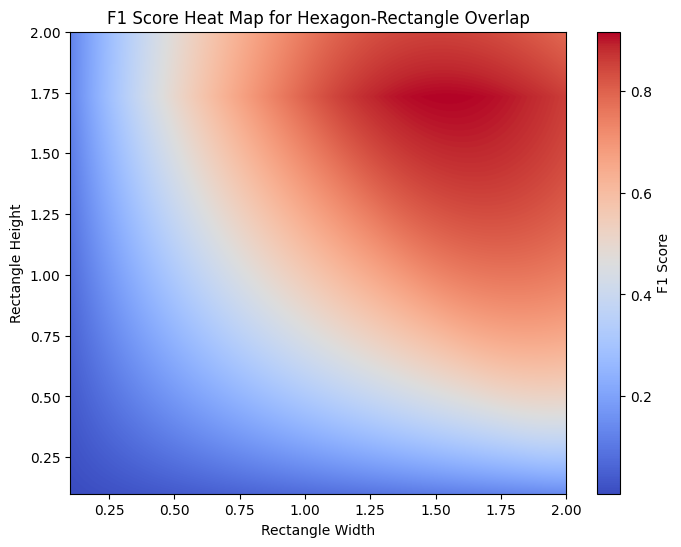

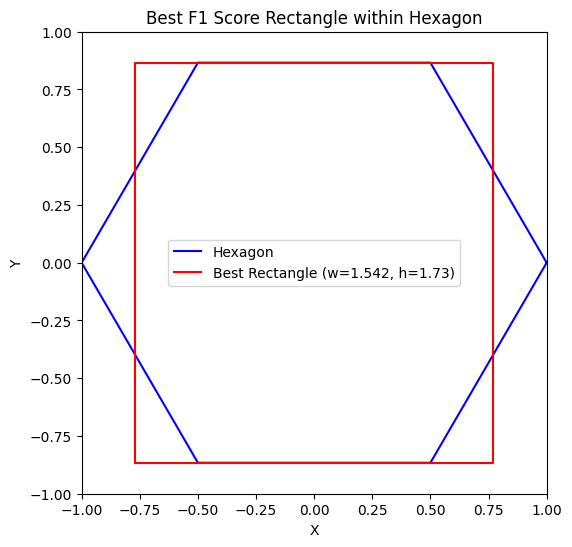

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import shapely.ops as ops

def create_hexagon(side_length=1):
    """Create a regular hexagon centered at the origin with a given side length."""
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # Six angles
    vertices = [(side_length * np.cos(a), side_length * np.sin(a)) for a in angles]
    return Polygon(vertices)

def create_rectangle(width, height):
    """Create a rectangle centered at the origin with given width and height."""
    half_w, half_h = width / 2, height / 2
    vertices = [(-half_w, -half_h), (half_w, -half_h), (half_w, half_h), (-half_w, half_h)]
    return Polygon(vertices)

def compute_f1(hexagon, rectangle):
    """Compute F1 score based on intersection, precision, and recall."""
    intersection = hexagon.intersection(rectangle).area
    precision = intersection / hexagon.area
    recall = intersection / rectangle.area if rectangle.area > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def simulate_f1():
    """Simulate the F1 score as the rectangle shrinks from the hexagon's bounding box and visualize with a heat map."""
    hexagon = create_hexagon()
    bbox = hexagon.bounds  # (minx, miny, maxx, maxy)
    max_width, max_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    max_overall = max(max_height, max_width)

    width_values = height_values = np.linspace(0.1, max_overall, 1000)

    f1_matrix = np.zeros((len(height_values), len(width_values)))
    best_f1, best_w, best_h = 0, 0, 0

    for i, h in enumerate(height_values):
        for j, w in enumerate(width_values):
            rectangle = create_rectangle(w, h)
            f1_score = compute_f1(hexagon, rectangle)
            f1_matrix[i, j] = f1_score
            if f1_score > best_f1:
                best_f1, best_w, best_h = f1_score, w, h

    plt.figure(figsize=(8, 6))
    plt.imshow(f1_matrix, extent=[0.1, max_overall, 0.1, max_overall], origin='lower', aspect='auto', cmap='coolwarm')
    plt.colorbar(label='F1 Score')
    plt.xlabel('Rectangle Width')
    plt.ylabel('Rectangle Height')
    plt.title('F1 Score Heat Map for Hexagon-Rectangle Overlap')
    plt.show()

    # Plot the hexagon and the best rectangle
    best_rectangle = create_rectangle(best_w, best_h)
    fig, ax = plt.subplots(figsize=(6, 6))

    x, y = hexagon.exterior.xy
    ax.plot(x, y, 'b-', label='Hexagon')

    x, y = best_rectangle.exterior.xy
    ax.plot(x, y, 'r-', label=f'Best Rectangle (w={best_w:.3f}, h={best_h:.3})')

    ax.set_xlim(-max_overall / 2, max_overall / 2)
    ax.set_ylim(-max_overall / 2, max_overall / 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Best F1 Score Rectangle within Hexagon')
    ax.legend()
    plt.show()
    return f1_matrix, best_f1

# f1_matrix, best_f1 = simulate_f1()

In [107]:
# best_f1

0.9172130856707039

In [16]:
def create_map(bb, hexagon, intersection):
    if not bb:
        return None
    lat_center, lon_center = (bb.centroid.y, bb.centroid.x)
    m = folium.Map(location=(lat_center, lon_center), zoom_start=10)

    folium.Polygon(locations=[(lat, lon) for lon, lat in bb.exterior.coords], color="yellow", fill=True, fill_opacity=0.3, weight=2).add_to(m)

    folium.Polygon(locations=[(lat, lon) for lon, lat in hexagon.exterior.coords], color="blue", fill=True, fill_opacity=0.3, weight=2).add_to(m)

    if intersection:
        folium.Polygon(locations=[(lat, lon) for lon, lat in intersection.exterior.coords],
                       color="green", fill=True, fill_opacity=0.3, weight=2).add_to(m)

    return m


# ID = "4482873 5924711"
osm_id = '108296'
GEORELATION_DIR = r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\georelation\all_articles_with_at_lest_one_correctly_geocoded_toponym\llama-3.3-70b-instruct\20250206"
georelated_article = load_json_file(GEORELATION_DIR, osm_id)

georelation_prediction = georelated_article['georelation']

h3_index = h3.latlng_to_cell(
    georelation_prediction["coordinates of geographical unit"]["latitude"],
    georelation_prediction["coordinates of geographical unit"]["longitude"],
    get_h3_resolution_scaled(georelation_prediction["area in square km"])
)

hexagon = h3.cell_to_boundary(h3_index)

hexagon_coords = [(lon, lat) for lat, lon in hexagon]
hexagon_polygon = Polygon(hexagon_coords)
predicted_hexagon_area = get_area_sq_km(hexagon_polygon)
print(f"Predicted Hexagon area: {predicted_hexagon_area} square km")

bb_min_lat, bb_max_lat, bb_min_lon, bb_max_lon = get_bounding_box(osm_id)
if bb_min_lat is not None and bb_max_lat is not None and bb_min_lon is not None and bb_max_lon is not None:
    bounding_box_polygon = Polygon([(bb_min_lon, bb_min_lat), (bb_min_lon, bb_max_lat),
                                    (bb_max_lon, bb_max_lat), (bb_max_lon, bb_min_lat)])
    area = get_area_sq_km(bounding_box_polygon)
    print(f"Bounding box area: {area} square km")

    intersection = bounding_box_polygon.intersection(hexagon_polygon)

    if not intersection.is_empty:
        intersection_area = get_area_sq_km(intersection)
        print(f"Intersection area: {intersection_area} square km")

    m = create_map(bounding_box_polygon, hexagon_polygon, intersection)
else:
    print("Could not retrieve bounding box")

m

Predicted Hexagon area: 2100.4586866873415 square km
Bounding box area: 1037.4298753970627 square km
Intersection area: 985.8679777749273 square km


In [112]:
correct_points = [{

                "toponym": "Province of Loja",

                "reasoning": "The only candidate with the same name as the toponym in the article is the Province of Loja in Ecuador. Since it becomes clear from the article that a province is mentioned, the other parameters like fclName, population, etc. match this.",

                "selected_candidate_geonameId": 3654667,

                "coordinates": {

                    "latitude": "-3.99313",

                    "longitude": "-79.20422"

                }

            },

            {

                "toponym": "Catamayo",

                "reasoning": "The only candidate with the same name as the toponym in the article is the city of Catamayo in Ecuador. Since it becomes clear from the article that a city is mentioned, the other parameters like fclName, population, etc. match this.",

                "selected_candidate_geonameId": 3659599,

                "coordinates": {

                    "latitude": "-3.98661",

                    "longitude": "-79.35763"

                }

            },

            {

                "toponym": "Loja",

                "reasoning": "The only candidate with the same name as the toponym in the article is the city of Loja in Ecuador. Since it becomes clear from the article that a city is mentioned, the other parameters like fclName, population, etc. match this.",

                "selected_candidate_geonameId": 3654667,

                "coordinates": {

                    "latitude": "-3.99313",

                    "longitude": "-79.20422"

                }

            },

            {

                "toponym": "Quilanga",

                "reasoning": "The only candidate with the same name as the toponym in the article is the second-order administrative division of Quilanga in Ecuador. Since it becomes clear from the article that a canton is mentioned, the other parameters like fclName, population, etc. match this.",

                "selected_candidate_geonameId": 10792497,

                "coordinates": {

                    "latitude": "-4.34159",

                    "longitude": "-79.37862"

                }

            },

            {

                "toponym": "Calvas",

                "reasoning": "The only candidate with the same name as the toponym in the article is the second-order administrative division of Calvas in Ecuador. Since it becomes clear from the article that a canton is mentioned, the other parameters like fclName, population, etc. match this.",

                "selected_candidate_geonameId": 3659882,

                "coordinates": {

                    "latitude": "-4.3353",

                    "longitude": "-79.60249"

                }

            },

            {

                "toponym": "Paltas",

                "reasoning": "The only candidate with the same name as the toponym in the article is the second-order administrative division of Paltas in Ecuador. Since it becomes clear from the article that a canton is mentioned, the other parameters like fclName, population, etc. match this.",

                "selected_candidate_geonameId": 3653515,

                "coordinates": {

                    "latitude": "-4.0281",

                    "longitude": "-79.74314"

                }

            }

        ]


for loc in correct_points:
    folium.Marker(
        location=[loc['coordinates']['latitude'], loc['coordinates']['longitude']],
        popup=loc['toponym'],
        tooltip=loc['toponym']
    ).add_to(m)
m

In [45]:
len(evaluation_results)

510

# GeoRelating

In [84]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner') # initialize neural pipeline

2025-03-13 17:25:21 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-03-13 17:25:21 INFO: Downloaded file to C:\Users\kaimo\stanza_resources\resources.json
2025-03-13 17:25:21 WARNING: Language en package default expects mwt, which has been added
2025-03-13 17:25:22 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2025-03-13 17:25:22 INFO: Using device: cpu
2025-03-13 17:25:22 INFO: Loading: tokenize
2025-03-13 17:25:22 INFO: Loading: mwt
2025-03-13 17:25:22 INFO: Loading: ner
2025-03-13 17:25:27 INFO: Done loading processors!


In [91]:
# article_name = "ahrtal_floods"
# article_text = "At least 19 people have died and dozens are reported missing as record rainfall in western Germany caused rivers to burst their banks, swept away homes and inundated cellars. Police said four people had died and 70 were missing on Thursday around the wine-growing hub of Ahrweiler, in Rhineland-Palatinate state, after the Ahr River that flows into the Rhine burst its banks and brought down half a dozen houses. “We have never seen such a catastrophe, it is truly devastating,” Rhineland-Palatinate premier Malu Dreyer told state lawmakers. To the north, in North Rhine-Westphalia, two people were found dead in flooded cellars in Cologne, with further deaths in Solingen, Unna and Rheinbach, police said. On Wednesday night, two firefighters died in the state – one drowned while the other collapsed after a rescue mission. About 50 people were stranded on roofs in Ahrweiler, and more houses were at risk of collapse. Police helicopters flew in from neighbouring states to winch people to safety, Koblenz police said. Weather experts said rains in the region over the past 24 hours had been unprecedented, as a near-stationary low-pressure weather system caused sustained local precipitation also to the west in France and the Netherlands. More heavy rainfall is due in southwestern Germany, on the upper reaches of the German Rhine, later on Thursday and Friday, the German Weather Service said."
# article_title = "Death toll rises in ‘devastating’ German floods"
# #https://www.aljazeera.com/gallery/2021/7/15/death-toll-rises-in-devastating-german-floods

# article_name = "central_europe_floods"
# article_text = "Residents in several regions of Poland and the Czech Republic on Monday evacuated their homes as central Europe began recovering from the worst flooding in over 20 years, which has resulted in widespread damage and an increasing death toll. The border areas between Poland and the Czech Republic were heavily impacted over the weekend by torrential rains that began last week. Rising water levels led to the collapse of bridges, forced evacuations, and significant damage to vehicles and homes. Recent reports indicate that at least 17 fatalities have occurred due to the flooding stretching from Romania to Poland. On Monday afternoon, the mayor of Nysa, a town with over 40,000 residents in southern Poland, urged locals to evacuate immediately after a nearby floodbank was damaged. Industrial, residential areas hit hard In the northeastern Czech city of Ostrava, a breached barrier on the Odra River, where it meets the Opava River, resulted in flooding that affected the city’s industrial zone, including the BorsodChem chemical plant and the OKK Koksovny coking plant. Many residents were also being evacuated from nearby residential neighbourhoods. Meanwhile, in the Czech town of Litovel, where around 70 per cent of the area was submerged by water up to one metre deep (3.2 feet) on Monday, residents reported a swift and terrifying rise in water levels over the weekend."
# article_title = "Central Europe floods: Poland, Czech Republic evacuate amid 17 deaths"
# https://www.business-standard.com/world-news/central-europe-floods-poland-czech-republic-evacuate-amid-17-deaths-124091700590_1.html

# article_name = "zyklon_alfred"
# article_text = "In Australien erwarten Millionen Menschen besorgt die Ankunft von Zyklon „Alfred“. Der Tropensturm bewegt sich weiter langsam, aber sicher auf eine dicht besiedelte und auch bei Touristen beliebte Region an der Ostküste zu. Jüngsten Berechnungen von Meteorologen zufolge wird er wahrscheinlich am Samstagmorgen (Ortszeit) auf Land treffen - später als zunächst erwartet. Zuletzt befand sich „Alfred“ noch etwa 100 Kilometer südöstlich der Metropole Brisbane, mit rund 2,5 Millionen Einwohnern die drittgrößte Stadt des Landes. Es ist der erste Zyklon seit 50 Jahren, der in der Region die Küste erreichen wird. Die meisten Schulen, Supermärkte, Straßen und Flughäfen wurden vorsorglich geschlossen. Die Behörden hatten Hunderttausende Sandsäcke verteilt, damit die Menschen ihre Häuser und Geschäfte sichern konnten. Auch für Tiere wie Pferde und größeres Vieh wurden Evakuierungszentren eingerichtet. Bereits die ersten Ausläufer des Wirbelsturms rissen Bäume und Strommasten um. Mehr als 80.000 Anwohner sind schon jetzt ohne Strom, wie der Sender ABC berichtete. Ein Mann wurde in der Nähe der Kleinstadt Dorrigo von den Wassermassen in einen Fluss gerissen - die Einsatzkräfte suchten nach ihm. Neun Meter hohe Wellen Vor der Küste türmten sich rund neun Meter hohe Wellen, wie Jane Golding vom staatlichen Wetterdienst betonte. Die Brandung spülte viele der bekannten Strände fort. „Wir erleben bereits Erosion an den Stränden der Gold Coast, die in dicht besiedelten Gebieten von Surfers Paradise und Main Beach bis hinunter nach Burleigh und Coolangatta Klippen von bis zu zwei Metern Höhe verursacht hat“, sagte Natalie Edwards von Surf Life Saving Queensland. Zyklon „Alfred“ nähert sich Australiens Ostküste. Starkregen, Böen von bis zu 150 Kilometern pro Stunde und Monsterwellen werden vor allem in der Region zwischen der Sunshine Coast in Queensland und dem 300 Kilometer weiter südlich gelegenen Surfer-Hotspot Byron Bay in New South Wales erwartet. Die Behörden befürchten schwere Überschwemmungen. „Heftige bis örtlich extreme Regenfälle können zu gefährlichen und lebensgefährlichen Sturzfluten führen“, warnte der Wetterdienst. „Ich rate allen, die in der Evakuierungszone leben oder sich dort aufhalten, dringend, das Gebiet jetzt zu verlassen“, sagte Polizeisprecher Scott Tanner. „Das Wetter wird sich in den nächsten Stunden verschlechtern, und dann könnte es zu spät sein, um sich in Sicherheit zu bringen.“"
# article_title = "Zyklon „Alfred“ nähert sich Australiens Ostküste"
#https://www.faz.net/aktuell/gesellschaft/ungluecke/zyklon-alfred-naehert-sich-australiens-ostkueste-110341897.html

article_name = "the_mountain_wildfire"
article_text = "A fast-moving wildfire erupted in Southern California on Wednesday, destroying homes and sending firefighters rushing to get residents out of homes and to safety, officials said. \nThe Mountain Fire in Ventura County prompted evacuation orders and grew to over 14,000 acres, fueled by what fire officials called a significant Santa Ana wind event. \nFirefighters at the scene of the brush fire, which broke out between the communities of Moorpark and Somis, “were faced with a tough firefight,” Ventura County Fire Capt. Trevor Johnson said. \n“Firefighters were right off the bat engaged in pulling people out of their houses and saving lives,” Johnson said. \nThe fire was moving so fast that firefighters drove residents out of the area in fire engines because of the danger, he said. \nThe fire department did not have a count for the number of destroyed structures. The fire began at 8:51 a.m. local time, said the California Department of Forestry and Fire Protection, known as Cal Fire. It was 0% contained Wednesday afternoon, and what sparked it was under investigation."
article_title = "California wildfire fueled by high winds grows to over 14,000 acres and forces evacuations"
#https://www.nbcnews.com/news/us-news/california-mountain-fire-fueled-high-winds-evacuat-rcna179047

# article_name = "earthquakes_santorini"
# article_text = "Die Erdbebenserie rund um die beliebte Ferieninsel Santorini dauert an. Die Menschen, die auf der Insel geblieben sind, wurden am Wochenende immer wieder in Angst versetzt und nachts aus dem Schlaf gerissen. Nach Angaben der Behörden hat die Erde seit dem 1. Februar Hunderte Male gebebt. Die Frequenz der Beben hat aber etwas nachgelassen. Die Seismologen geben aber keine Entwarnung. Es könnte doch noch ein größeres Beben geben, heißt es immer wieder seitens der Experten.\nSchulen bleiben geschlossen – viele Einwohner geflohen\nDie Regierung hat beschlossen, dass die Schulen auf Santorini und den benachbarten Eilanden Ios, Anafi und Amorgos auch kommende Woche geschlossen bleiben. \nDer größte Teil der Bevölkerung - vor allem Frauen, Kinder und ältere Menschen - hat die Insel verlassen und sich auf dem Festland in Sicherheit gebracht. \nAuf den Straßen trifft man Feuerwehrleute, Beamte des Zivilschutzes und der Polizei an, die aus anderen Regionen des Landes nach Santorini und den umliegenden Inseln gebracht worden sind - für den Fall, dass es zu einem schweren Erdbeben kommt. \nDie Stadt Athen hat zahlreiche Holzhäuser in einem Sommerlager für die Menschen geöffnet, die kein Geld oder Verwandte haben, um eine neue Bleibe zu finden, bis das Phänomen um Santorini endet. \nGefahr durch Vulkanaktivität?\nUnklar bleibt weiterhin, inwiefern die Erdbebenserie, die sich hauptsächlich zwischen den Inseln Santorini und Amorgos ereignet, die Vulkane der Region „geweckt“ haben könnte - eine Frage, die die Einwohner besorgt. \n1950 hatte eine Eruption des Vulkans von Santorini schwere Schäden angerichtet. Die Meinungen der Geologen und Seismologen gehen auseinander. Einige Experten schließen eine Eruption aus, andere halten sie für möglich.\nAusharrende geben sich gelassen\nViele Einwohner versuchen, sich Mut zu machen. Ein Mann aus Santorini sagte der Athener Zeitung „Kathimerini“ (Sonntag): „Santoriner zu sein bedeutet, auf einer Bombe zu leben und sich nicht darum zu kümmern.“"
# article_title = "Kein Ende der Beben um Santorini"
# dpa:250209-930-369654/1

In [119]:
doc = nlp(article_text) # run annotation over a sentence
print(doc.entities)

[{
  "text": "Moorpark",
  "type": "GPE",
  "start_char": 58,
  "end_char": 66
}, {
  "text": "Somis",
  "type": "GPE",
  "start_char": 71,
  "end_char": 76
}]


In [87]:
toponym_list = [entity.text for entity in doc.entities if entity.type in ["LOC", "GPE"]]

In [22]:
"""
Initialize GeoCoder
"""
from helpers.helpers import preprocess_data
from models.candidates import CandidateGenerationState, GeoCodingState
import time
from modules.reflective_geocoding import ReflectiveGeoCoder

call_times = []
actor = "llama-3.3-70b-instruct"  # ["deepseek-r1-distill-llama-70b", "meta-llama-3.1-8b-instruct", "llama-3.3-70b-instruct", "mistral-large-instruct"]
critic = "mistral-large-instruct"
dataset = "New"

geocoder = ReflectiveGeoCoder(
    actor_model_name=actor,
    critic_model_name=critic,
    call_times=call_times,
    skip_few_shot_loader=False,
    data_set=dataset
)

"""
Reflective Candidate Generation
"""
generation_graph_builder = geocoder.build_graph()
generation_agent_graph = generation_graph_builder.compile()

In [71]:
start = time.time()
input_state = {
        "article_id": "002",
        "article_title": article_title,
        "article_text": article_text,
        "toponyms": toponym_list
}

# Invoke the graph
generation_agent_graph_answer = generation_agent_graph.invoke(input_state)
candidate_generation = CandidateGenerationState(**generation_agent_graph_answer)
print(f"generation with {actor}_with_{critic}_critic : time taken: {time.time() - start} seconds.")

C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\agent_components\memory\working_memory.py:29: LangChainDeprecationWarning: This class is deprecated. Please see the docstring below or at the link for a replacement option: https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.pipeline.PipelinePromptTemplate.html
  return PipelinePromptTemplate(


generation with llama-3.3-70b-instruct_with_mistral-large-instruct_critic : time taken: 24.68872857093811 seconds.


In [78]:
"""
Run reflective candidate resolution graph
"""
candidate_generation_dict = preprocess_data(candidate_generation.model_dump(), GeoCodingState)
resolution_graph_builder = geocoder.build_resolution_graph()
resolution_agent_graph = resolution_graph_builder.compile()
start = time.time()
resolution_agent_graph_answer = resolution_agent_graph.invoke(candidate_generation_dict)
candidate_resolution = GeoCodingState(**resolution_agent_graph_answer)
print(f"resolution with {actor}_with_{critic}_critic for: time taken: {time.time() - start} seconds.\n")

resolution with llama-3.3-70b-instruct_with_mistral-large-instruct_critic for: time taken: 38.355796813964844 seconds.



In [88]:
"""
GeoRelation
"""
from models.candidates import GeoCodingState
with open(r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\georelation\georelating\the_mountain_fire_geocoding.json", "r", encoding="utf-8") as f:
    candidate_resolution = json.load(f)
    candidate_resolution = GeoCodingState(**candidate_resolution)
geocoded_toponyms = []
for topo in candidate_resolution.valid_geocoded_toponyms:
    for item in candidate_resolution.toponyms_with_candidates:
        if item.toponym_with_search_arguments.toponym.casefold() == topo.toponym.casefold():
            # get the candidate with the correct geonameid
            incorrect_geonameid = True
            for candidate in item.candidates:
                if topo.selected_candidate_geonameId == candidate["geonameId"]:
                    topo.coordinates = {"latitude": candidate["lat"],
                                        "longitude": candidate["lng"]}
                    geocoded_toponyms.append(topo)
                    break
            break
geocoded_toponyms = [toponym.model_dump() for toponym in geocoded_toponyms]

In [89]:
thoughts, prediction = georelate("deepseek-r1-distill-llama-70b", geocoder.working_memory.long_term_memory, article_text, geocoded_toponyms)

In [93]:
with open(r"C:\Users\kaimo\Uni\Master\5_WS24_25-MA\geoparse-natural-disasters-with-llms\output\georelation\georelating\the_mountain_fire_georelation_llama_distill_R1.json", "r", encoding="utf-8") as f:
    output = json.load(f)
thoughts = output['georelation_thoughts']
prediction = output['georelation']
print(thoughts)
print(json.dumps(prediction, indent = 4))

["\nAlright, I'm trying to figure out how to respond to this query. The user has provided an article about a wildfire in Southern California, specifically in Ventura County. They've also given me a list of mentioned toponyms with their coordinates. My task is to determine the coordinates of the main geographical unit discussed in the article and estimate its area.\n\nFirst, I need to understand the structure of the problem. The article is about the Mountain Fire in Ventura County. The main geographical unit here is the fire itself, but since fires don't have fixed coordinates, I think the user is asking for the origin point or the general area where the fire occurred.\n\nLooking at the mentioned toponyms, I see Southern California, Ventura County, Santa Ana, Moorpark, Somis, and Ventura County again. The coordinates for these places are provided. The fire broke out between Moorpark and Somis, so the location should be somewhere in that vicinity.\n\nI should check the coordinates for Mo

In [81]:
if 'output' in prediction:
    prediction = prediction['output']
prediction_to_save = candidate_resolution.model_dump()
prediction_to_save["georelation"] = prediction
prediction_to_save["georelation_thoughts"] = thoughts
with open(f"{article_name}_llama.json", "w", encoding="utf-8") as f:
            json.dump(prediction_to_save, f, ensure_ascii=False, indent=4, cls=CustomJSONEncoder)

In [118]:
h3_res = get_h3_resolution_scaled(prediction["area in square km"])
h3_index = h3.latlng_to_cell(
    prediction["coordinates of geographical unit"]["latitude"],
    prediction["coordinates of geographical unit"]["longitude"],
    h3_res
)

hexagon = h3.cell_to_boundary(h3_index)

hexagon_coords = [(lon, lat) for lat, lon in hexagon]
hexagon_polygon = Polygon(hexagon_coords)
predicted_hexagon_area = get_area_sq_km(hexagon_polygon)
lat_center, lon_center = (prediction["coordinates of geographical unit"]["latitude"], prediction["coordinates of geographical unit"]["longitude"])
hex_popup_text = f"Selected H3 cell: <b>{h3_index}</b><br>Predicted area: <b>{prediction["area in square km"]} km²</b>"
hex_popup_html = f'<div style="font-size: 30px;">{hex_popup_text}</div>'
hex_popup = folium.Popup(
    hex_popup_html,
    max_width=450,
    show=True,
    sticky=True,
    style={"font-size": "30px", "color": "blue"}
)
m = folium.Map(location=(lat_center, lon_center), zoom_start=10)
folium.Polygon(locations=[(lat, lon) for lon, lat in hexagon_polygon.exterior.coords], color="red", fill=True, fill_opacity=0.3, weight=2, popup=hex_popup, tooltip=h3_index).add_to(m)
for loc in geocoded_toponyms:
    popup = folium.Popup(
        f'<div style="font-size: 24px;"><b>{loc['toponym']}</b><br>GeoNames ID: {loc['selected_candidate_geonameId']}</div>',
        max_width=350,
        show=True,
        sticky=True
    )
    folium.Marker(
        location=[loc['coordinates']['latitude'], loc['coordinates']['longitude']],
        popup=popup,
        tooltip=loc['toponym']
    ).add_to(m)
m.save(f"{article_name}_distill.html")
m

In [14]:
import urllib.parse
import requests
import os
import folium
import json

base_url = "http://api.geonames.org/search?"

params = {"name_equals": "Moorpark",
          "username": "KaiMo",
          "type": "json",
          "style": "full"}
url = base_url + urllib.parse.urlencode(params)
response = requests.get(url)
if response.status_code != 200:
    response = requests.get(url) #retry once
    if response.status_code != 200:
        raise Exception(f"Error in GeoNamesAPI.search: {response.text}")
all_moorparks = response.json()
moorparks_map = folium.Map()
for loc in all_moorparks['geonames']:
    folium.Marker(
        location=[loc['lat'], loc['lng']],
        popup=loc['name'],
        tooltip=loc['name']
    ).add_to(moorparks_map)
moorparks_map.save("all_moorparks_map.html")
print(json.dumps(all_moorparks, indent=4))
moorparks_map

{
    "totalResultsCount": 3,
    "geonames": [
        {
            "timezone": {
                "gmtOffset": -8,
                "timeZoneId": "America/Los_Angeles",
                "dstOffset": -7
            },
            "bbox": {
                "east": -118.82076700000002,
                "south": 34.259003,
                "north": 34.30791,
                "west": -118.92083099999998,
                "accuracyLevel": 10
            },
            "asciiName": "Moorpark",
            "astergdem": 152,
            "countryId": "6252001",
            "fcl": "P",
            "srtm3": 160,
            "score": 135.74127197265625,
            "adminId2": "5405889",
            "countryCode": "US",
            "adminCodes1": {
                "ISO3166_2": "CA"
            },
            "adminId1": "5332921",
            "lat": "34.28556",
            "fcode": "PPL",
            "continentCode": "NA",
            "elevation": 157,
            "adminCode2": "111",
            "admi